<a href="https://colab.research.google.com/github/AALivanova/BI_Stat_2021/blob/ML_hw9/PlantNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключим гугл-драйв, где в папке лежит часть датасета PlantNet, содержащий 200 папок с картинками. Эти папки содержат иллюстрации 200 видов растений

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Распакуем архив

In [ ]:
!unzip /content/gdrive/MyDrive/PlantNet/PlantNet4.zip

Archive:  /content/gdrive/MyDrive/PlantNet/PlantNet4.zip
warning [/content/gdrive/MyDrive/PlantNet/PlantNet4.zip]:  7948840424 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/gdrive/MyDrive/PlantNet/PlantNet4.zip]:  start of central directory not found;
  zipfile corrupt.
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [ ]:
! 7z x /content/gdrive/MyDrive/PlantNet/PlantNet4.zip -o/content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/MyDrive/PlantNet/                                           1 file, 12258055625 bytes (12 GiB)

Extracting archive: /content/gdrive/MyDrive/PlantNet/PlantNet4.zip
  0% 256 Open               0% 512 Open               1% 1024 Open                1% 1280 Open                2% 1792 Open                3% 2048 Open                3% 2304 Open                3% 2560 Open                4% 3072 Open              

## Импорты

In [ ]:
!pip install loguru
import pickle
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import seaborn as sns

from os.path import join
from loguru import logger
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import nn
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score

from sklearn.metrics import classification_report
import pandas as pd

import json

     |████████████████████████████████| 58 kB 3.9 MB/s 


Указываем путь до папок с трейн и вал-датасетами, размер rescale, устройство и размера батча для будущей нейросети

In [ ]:
PATH_TO_TRAIN = "/content/PlantNet4/train"
PATH_TO_TEST = "/content/PlantNet4/val"
RESCALE_SIZE = 224, 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 40

print(f"Using device: {DEVICE}")

Using device: cuda


Класс датасета

In [ ]:
class PlantDataset(Dataset):
    def __init__(self, files, mode="train") -> None:
        super().__init__()

        self.files = sorted(list(files))
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()
        self.mode = mode

        self.labels = [path.parent.name for path in self.files]
        self.label_encoder.fit(self.labels)

        if self.mode == "train":
          # '/content/gdrive/MyDrive/PlantNet/Model/big_model_label_encoder.pkl'
            with open("/content/gdrive/MyDrive/PlantNet/Model/big_model_label_encoder.pkl", "wb") as le_dump_file:
                    pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == "train":
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.ToTensor(),
                        #transforms.Normalize([0.572], [0.048])
            ])
        
        else:
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.ToTensor(),
                        #transforms.Normalize([0.572], [0.048])
            ])

        x = self.load_sample(self.files[index])
        x = transform(x)

        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()

        return x, y

In [ ]:
train_files = sorted(list(Path(PATH_TO_TRAIN).rglob("*.jpg")))
train_labels = [path.parent.name for path in train_files]

test_files = sorted(list(Path(PATH_TO_TEST).rglob("*.jpg")))
test_labels = [path.parent.name for path in test_files]
N_CLASSES = len(set(test_labels))
N_CLASSES

200

In [ ]:
# создадим словарь, который будет переводить условные обозначения в виды. 
dict_mini_classifier = {}
file_ = '/content/gdrive/MyDrive/PlantNet/plantnet300K_species_id_2_name.json'
with open(file_, 'r') as f:
  in_dict = json.loads(f.read())
  for class_name in set(train_labels):
    dict_mini_classifier[class_name] = in_dict[class_name]

with open('/content/gdrive/MyDrive/PlantNet/10classes.json', 'w') as out_f:  # надо 200
  json.dump(dict_mini_classifier, out_f)


def get_species_name(class_name):
  return dict_mini_classifier[class_name]

Узнаем вид растения и расшифруем его

In [ ]:
test_files[100].parent.name

'1355932'

In [ ]:
get_species_name('1355978')

"Pelargonium zonale (L.) L'Hér."

Узнаем, что там с дисбалансом классов

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


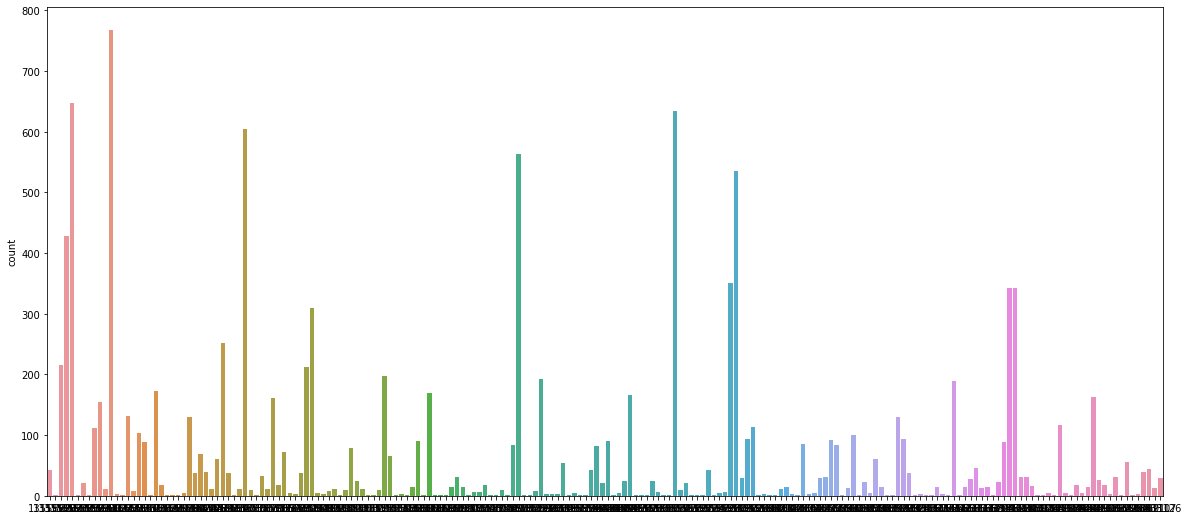

In [ ]:
plt.figure(figsize=(20, 9))
sns.countplot(test_labels);

Дисбаланс присутствует, а значит придется вводить веса для каждого класса

In [ ]:
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler


class_numbers = Counter(train_labels)
samples_weight = torch.tensor([1 / class_numbers[i] for i in train_labels])

sampler = WeightedRandomSampler(samples_weight.type("torch.DoubleTensor"), len(samples_weight))

Создаем лоадеры


In [ ]:
trainset = PlantDataset(train_files)
valset = PlantDataset(test_files, mode="val")


trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, sampler=sampler) #вот тут пришлось поменять шаффл на False, потому что вместе с семплером падало
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
len(valset)

11779

In [ ]:
valset[0][0].shape

torch.Size([3, 224, 224])

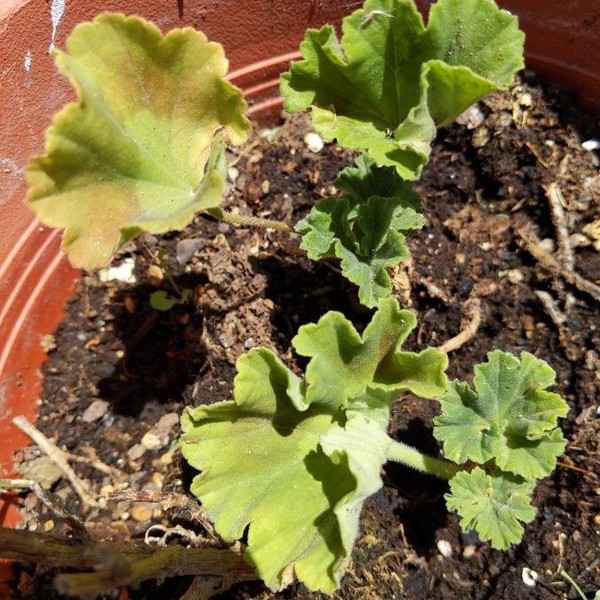

In [ ]:
trainset.load_sample('/content/PlantNet4/train/1355932/001860c7cbca508bab69c07a14887f5eda10e1db.jpg')

In [ ]:
valset.__len__()

11779

Класс для обучения сети

In [ ]:
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,
                 validate=True, scheduler=None,
                 verbose=2):
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler
        self.get_probs = nn.Softmax(dim=-1)
        self.train_losses = []
        self.valid_losses = []
        self.train_metrics = []
        self.valid_metrics = []

    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader)
            self.train_losses.append(train_loss)
            self.train_metrics.append(train_metric)

            if self.validate:
                val_loss, val_metric = self._validate(self.validloader)
                self.valid_losses.append(val_loss)
                self.valid_metrics.append(val_metric)
                if len(self.valid_metrics) == 1 or self.valid_metrics[-1] > max(self.valid_metrics[:-1]):
                    torch.save(self.model.state_dict(), '/content/gdrive/MyDrive/PlantNet/Model/big_model_color_state_dict.pt')  # state dict

                if self.scheduler is not None:
                    self.scheduler.step(val_loss)
            else:
                val_loss = "NO"

            if self.verbose > 0:
                print()
                print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                         Train metric = {train_metric}, validation metric = {val_metric}")
                print()
        
        return self

    def _train(self, loader):
        self.model.train()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            out = self.model(inputs)
            loss = self.criterion(out, targets)
            epoch_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step()

            out = self.get_probs(out)
            _, preds = torch.max(out.data, 1)
            epoch_preds += list(preds.cpu())
            epoch_targets += list(targets.detach().cpu())

            self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)              
                out = self.model(inputs)
                loss = self.criterion(out, targets)

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item()
                out = self.get_probs(out)
                _, preds = torch.max(out.data, 1)
                epoch_preds += list(preds.cpu())
                epoch_targets += list(targets.detach().cpu())

                self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric
    
    def _clear_vram(self, inputs, labels, outputs):
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()

In [ ]:
def predict(model, loader):
    model.eval()
    predictions = []
    targ = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)              
            out = model(inputs)
            out = nn.functional.softmax(out, dim=-1)
            _, preds = torch.max(out.data, 1)
            predictions += list(preds)
            targ += list(targets)
    
    return predictions, targ

def calculate_metric(model, loader, metric=None):
    if metric is None:
        metric = accuracy_score
    
    preds, targets = predict(model, loader)
    preds = [i.item() for i in preds]
    targets = [i.item() for i in targets]

    return metric(targets, preds)

Модель VGG19

In [ ]:
model = torchvision.models.vgg19_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
num_features = 25088
model.classifier = nn.Linear(num_features, N_CLASSES)
model.features[0] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  # color

model = model.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

Обучение

In [ ]:
trainer = Trainer(model, 10, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score)
trainer.fit()

Training: batch 2332 out of 2332
Validation: batch 295 out of 295

Epoch 1 out of 10: Train loss = 1.1516875542355238, validation loss = 1.7499622881412507 
                                         Train metric = 0.7262686054990778, validation metric = 0.543594532642839

Training: batch 2332 out of 2332
Validation: batch 295 out of 295

Epoch 2 out of 10: Train loss = 0.43569975096962416, validation loss = 1.6450280980538514 
                                         Train metric = 0.8813966456483507, validation metric = 0.5807793530860005

Training: batch 2332 out of 2332
Validation: batch 295 out of 295

Epoch 3 out of 10: Train loss = 0.30390625245274905, validation loss = 1.4645358157359947 
                                         Train metric = 0.9150795693389954, validation metric = 0.6236522625010612

Training: batch 2332 out of 2332
Validation: batch 295 out of 295

Epoch 4 out of 10: Train loss = 0.23675325407453304, validation loss = 1.5069187384035627 
                      

Мы учимся.

In [ ]:
sns.lineplot(y=trainer.train_losses, x=range(1, 11), label="Train")
sns.lineplot(y=trainer.valid_losses, x=range(1, 11), label="Validation")

plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()

    return probs


def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = np.clip(inp, 0, 1)
    # plt_ax.imshow(inp.reshape((*RESCALE_SIZE, 3)))
    plt_ax.imshow(inp.permute(1, 2, 0))
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


def get_predicts(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

    return probs

In [ ]:
label_encoder = trainset.label_encoder

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 50))
    im_val, label = valset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                valset.label_encoder.inverse_transform([label])[0].split("_")))
    
    

    imshow(im_val.data.cpu(), \
          title=get_species_name(img_label), plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color="white"))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)
    y_pred = np.argmax(prob_pred)
    
    predicted_label = get_species_name(label_encoder.classes_[y_pred])
    predicted_label = predicted_label[:len(predicted_label)//2] + "\n" + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.2f}".format(predicted_label, predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment="left", fontproperties=font,
                    verticalalignment="top", fontsize=12, color="black", fontweight="bold")

✍✍✍ Дорогой дневник... ✍✍✍ Сегодня меня... ✍ забуллил колаб... ✍✍✍
Я учила модель... полтора часа.... ✍✍✍ А затем он ✍✍ без предупреждения!!! ✍✍✍ отрубил мне среду выполнения... ✍✍✍

всё это время ✍ я чекала среду, чтобы она не отрубилась ✍✍✍ даже писала код в каких-то ✍✍✍ ячейках...
✍✍✍

В силу ✍ сложившихся ✍ обстоятельств ✍✍

Я опечалена.


В общем, я считаю, что это какой-то кошмар.

In [ ]:
print(model)

Блюп.
Ждём чуда.
Да.

In [ ]:
# да.